In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = '/content/drive/MyDrive/insurance_claims.csv'
df = pd.read_csv(file_path)


# **Data Preprocessing**

In [4]:
# 1. Handle missing values
df.replace('?', pd.NA, inplace=True)

# Fill missing values for 'collision_type', 'property_damage', and 'police_report_available' without using inplace
df['collision_type'] = df['collision_type'].fillna('None')
df['property_damage'] = df['property_damage'].fillna('No')
df['police_report_available'] = df['police_report_available'].fillna('No')

In [5]:
# 2. Convert date columns to datetime
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'], errors='coerce')
df['incident_date'] = pd.to_datetime(df['incident_date'], errors='coerce')

In [6]:
# 3. Drop irrelevant columns
df_cleaned = df.drop(columns=['policy_number', 'insured_zip', '_c39'])

<ipython-input-7-041f53a4482d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='fraud_reported', palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


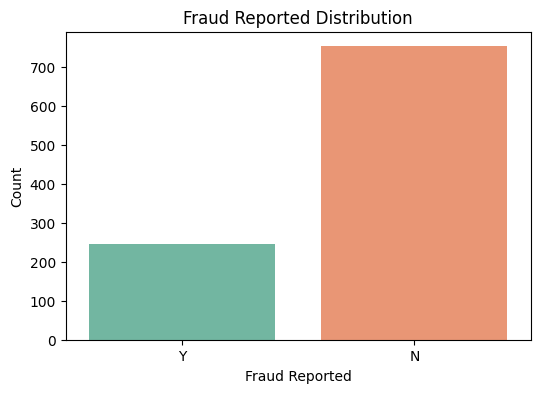

In [7]:
# 4. Visualize fraud reported distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_cleaned, x='fraud_reported', palette='Set2')
plt.title('Fraud Reported Distribution')
plt.xlabel('Fraud Reported')
plt.ylabel('Count')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


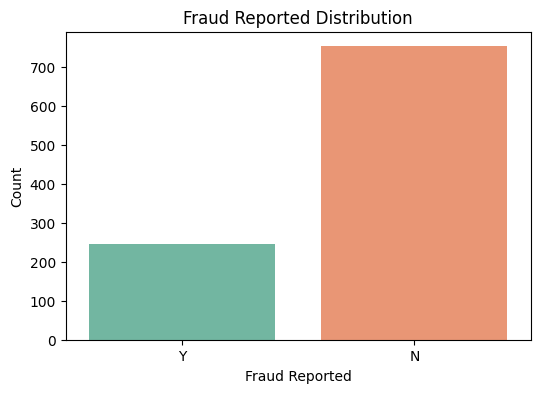

In [8]:
# Visualize fraud reported distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_cleaned, x='fraud_reported', hue='fraud_reported', palette='Set2', legend=False)
plt.title('Fraud Reported Distribution')
plt.xlabel('Fraud Reported')
plt.ylabel('Count')
plt.show()


In [9]:
# 5. Identify categorical columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

In [10]:
# 6. Apply One-Hot Encoding to categorical columns
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns[:-1], drop_first=True)

In [11]:
# 7. Encode the target variable 'fraud_reported' (Y = 1, N = 0)
df_encoded['fraud_reported'] = df_encoded['fraud_reported'].apply(lambda x: 1 if x == 'Y' else 0)

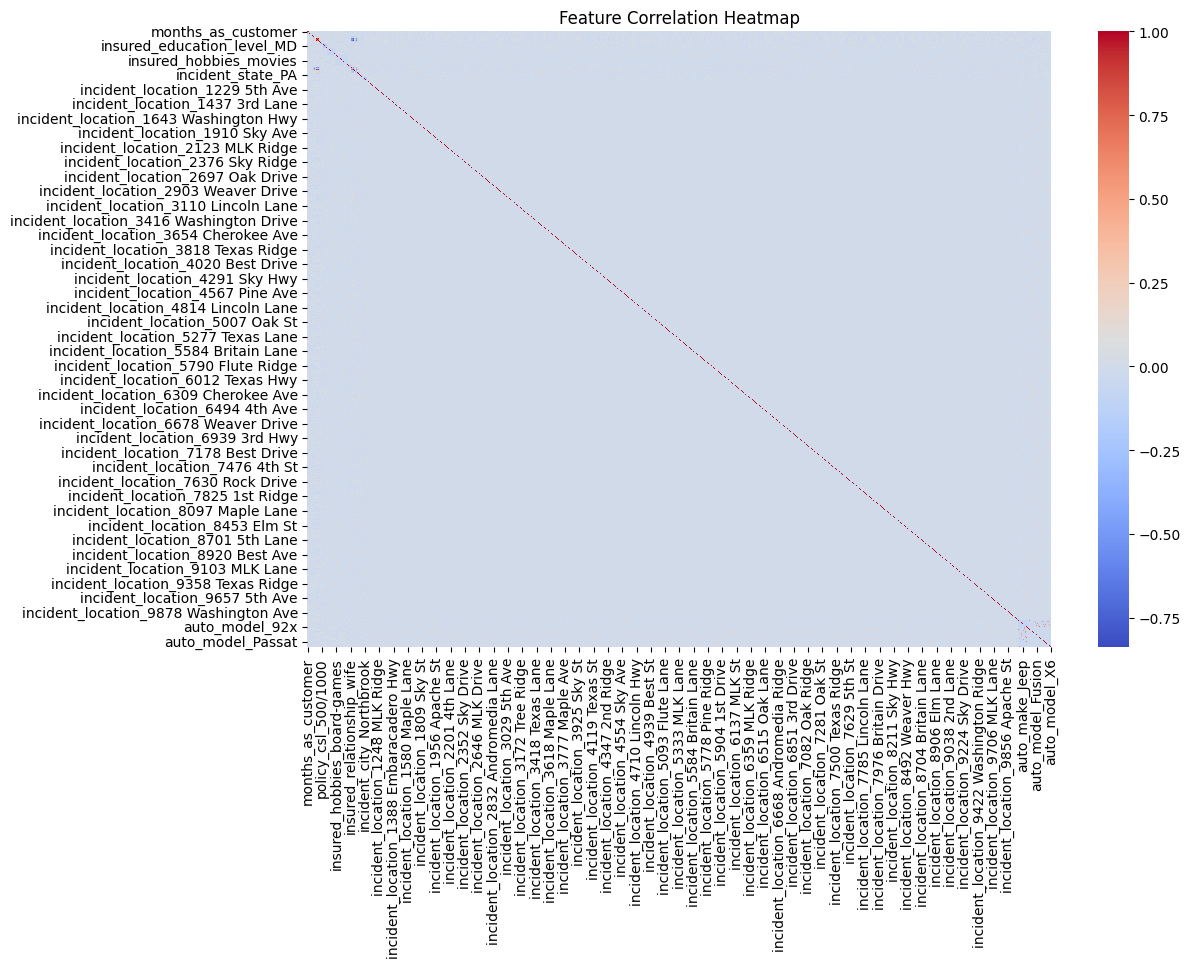

In [12]:
# 8. Visualize correlation heatmap to understand the relationships between features
plt.figure(figsize=(12,8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()


# Model - Recurrent Neural Network (RNN)

**Model Architecture**

In [14]:
!pip install tensorflow


In [15]:
# Import necessary libraries for building the RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
# Separate features and target
X = df_encoded.drop('fraud_reported', axis=1)
y = df_encoded['fraud_reported']


In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
print(X_train.columns)


Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'capital-gains',
       'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries',
       ...
       'auto_model_RSX', 'auto_model_Silverado', 'auto_model_TL',
       'auto_model_Tahoe', 'auto_model_Ultima', 'auto_model_Wrangler',
       'auto_model_X5', 'auto_model_X6', 'days_since_policy_bind',
       'days_since_incident'],
      dtype='object', length=1144)


In [24]:
# Reshape input data for RNN (RNN expects 3D input: [samples, time steps, features])
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


In [25]:
# Define the RNN model architecture
model = Sequential()
model.add(SimpleRNN(64, input_shape=(1, X_train_rnn.shape[2]), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │          77,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,489 (310.50 KB)

 Trainable params: 79,489 (310.50 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

# Define the RNN model architecture
model = Sequential()

# Add an input layer to explicitly define the input shape
model.add(Input(shape=(1, X_train_rnn.shape[2])))

# Add a SimpleRNN layer
model.add(SimpleRNN(64, activation='relu'))

# Add a Dense hidden layer
model.add(Dense(32, activation='relu'))

# Add an output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          77,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,489 (310.50 KB)

 Trainable params: 79,489 (310.50 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

In [28]:
# Train the RNN model
history = model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6125 - loss: 0.6695 - val_accuracy: 0.7000 - val_loss: 0.5701
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7749 - loss: 0.4516 - val_accuracy: 0.7312 - val_loss: 0.5538
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8666 - loss: 0.3016 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9594 - loss: 0.2097 - val_accuracy: 0.7563 - val_loss: 0.5372
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9858 - loss: 0.1351 - val_accuracy: 0.7563 - val_loss: 0.5354
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9882 - loss: 0.0882 - val_accuracy: 0.7563 - val_loss: 0.5372
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9999 - loss: 0.0458 - val_accuracy: 0.7625 - val_loss: 0.5401
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0282 - val_accuracy: 0.7437 - val_los

**Evaluation**

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7429 - loss: 0.6962  


In [30]:
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 72.50%
Test Loss: 0.8003


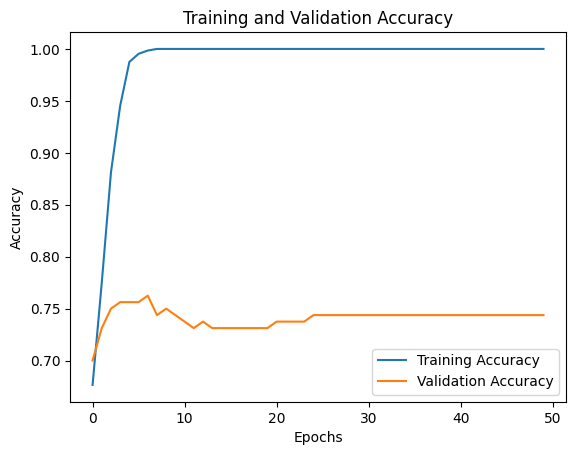

In [31]:
# Visualize the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

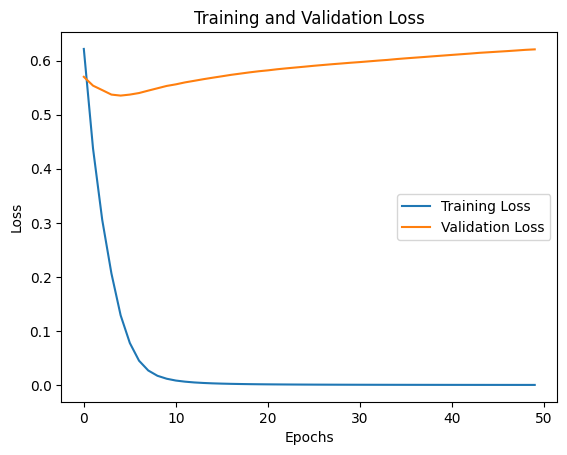

In [32]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


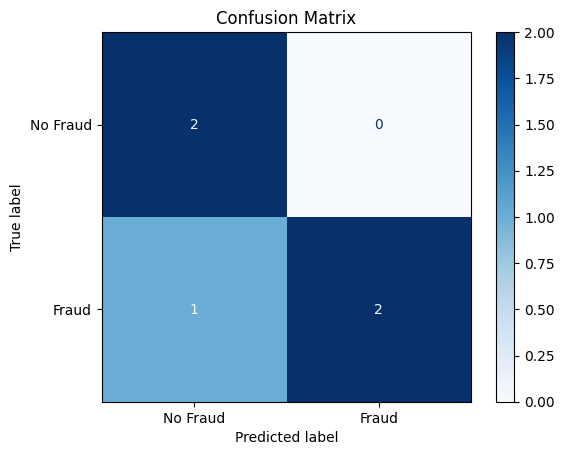

In [37]:
# Optional: Plot training history
import matplotlib.pyplot as plt
# Import the ConfusionMatrixDisplay class
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Assuming you have y_true (true labels) and y_pred (predicted labels)
# Replace these with your actual variable names
# The original lists were empty, leading to an empty confusion matrix
# Populate these lists with your actual data
y_true = [0, 1, 0, 1, 1]  # Example true labels - replace with your data
y_pred = [0, 0, 0, 1, 1]  # Example predicted labels - replace with your data


# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9534 - loss: 0.1210 - val_accuracy: 0.7200 - val_loss: 1.8791
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9950 - loss: 0.0193 - val_accuracy: 0.7150 - val_loss: 0.9838
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.7100 - val_loss: 0.9641
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.6899e-04 - val_accuracy: 0.7150 - val_loss: 1.0055
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.5840e-04 - val_accuracy: 0.7200 - val_loss: 1.0358
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5731e-04 - val_accuracy: 0.7200 - val_loss: 1.0599
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9143e-04 - val_accuracy: 0.7300 - val_loss: 1.0763
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.5674e-04 - val_accuracy

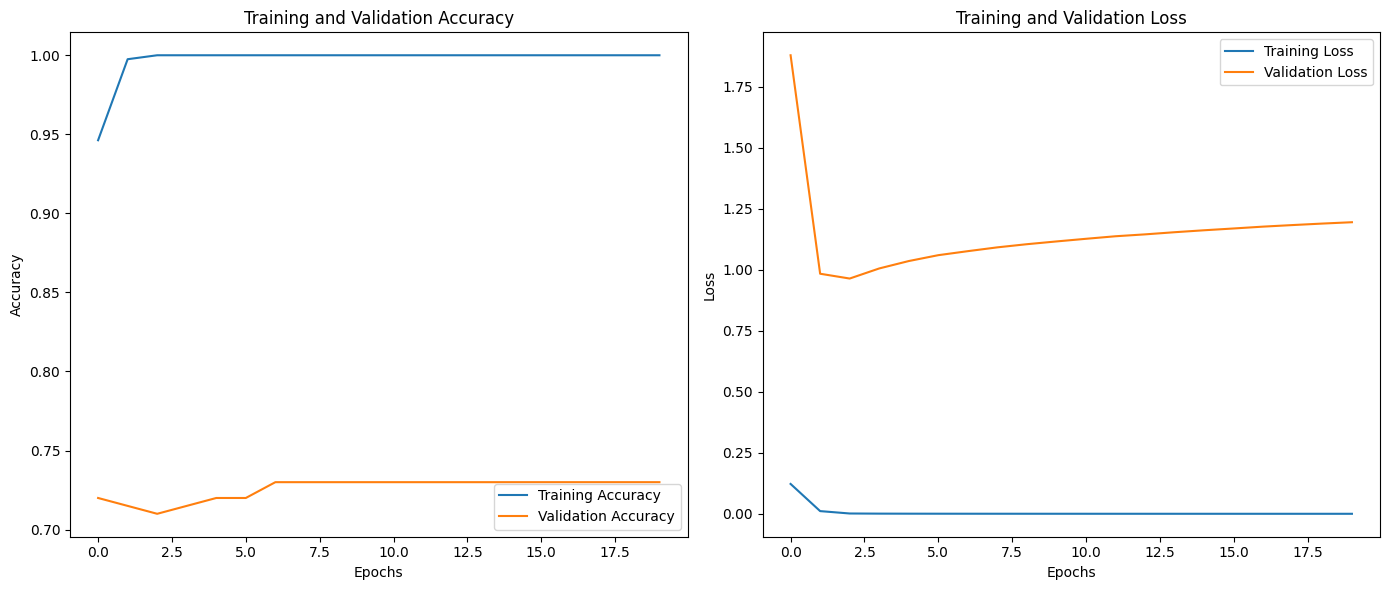

In [38]:
# Set the number of epochs and batch size
epochs = 20
batch_size = 32

# Train the model
history = model.fit(X_train_rnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rnn, y_test),
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Visualize the training and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3154e-04 - val_accuracy: 0.7300 - val_loss: 1.2012
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6429e-04 - val_accuracy: 0.7300 - val_loss: 1.2063
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0872e-04 - val_accuracy: 0.7300 - val_loss: 1.2119
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.0875e-04 - val_accuracy: 0.7300 - val_loss: 1.2165
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4017e-05 - val_accuracy: 0.7300 - val_loss: 1.2220
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2107e-04 - val_accuracy: 0.7300 - val_loss: 1.2270
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4559e-05 - val_accuracy: 0.7300 - val_loss: 1.2320
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 8.6551e-05 - 

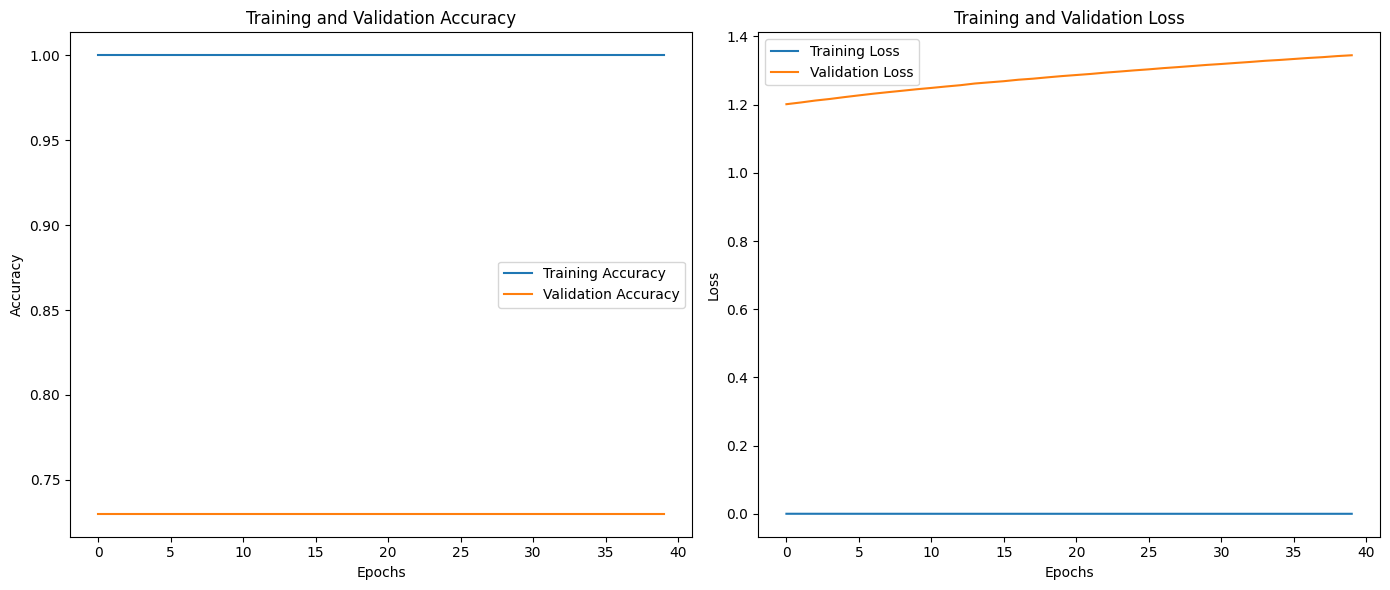

In [40]:
# Set the number of epochs and batch size
epochs = 40
batch_size = 32

# Train the model
history = model.fit(X_train_rnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rnn, y_test),
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Visualize the training and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 2.8452e-05 - val_accuracy: 0.7300 - val_loss: 1.3475
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.7218e-05 - val_accuracy: 0.7300 - val_loss: 1.3503
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.5001e-05 - val_accuracy: 0.7300 - val_loss: 1.3526
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7085e-05 - val_accuracy: 0.7300 - val_loss: 1.3557
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.3580e-05 - val_accuracy: 0.7300 - val_loss: 1.3578
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9214e-05 - val_accuracy: 0.7300 - val_loss: 1.3607
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4119e-05 - val_accuracy: 0.7300 - val_loss: 1.3632
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3489e-05 -

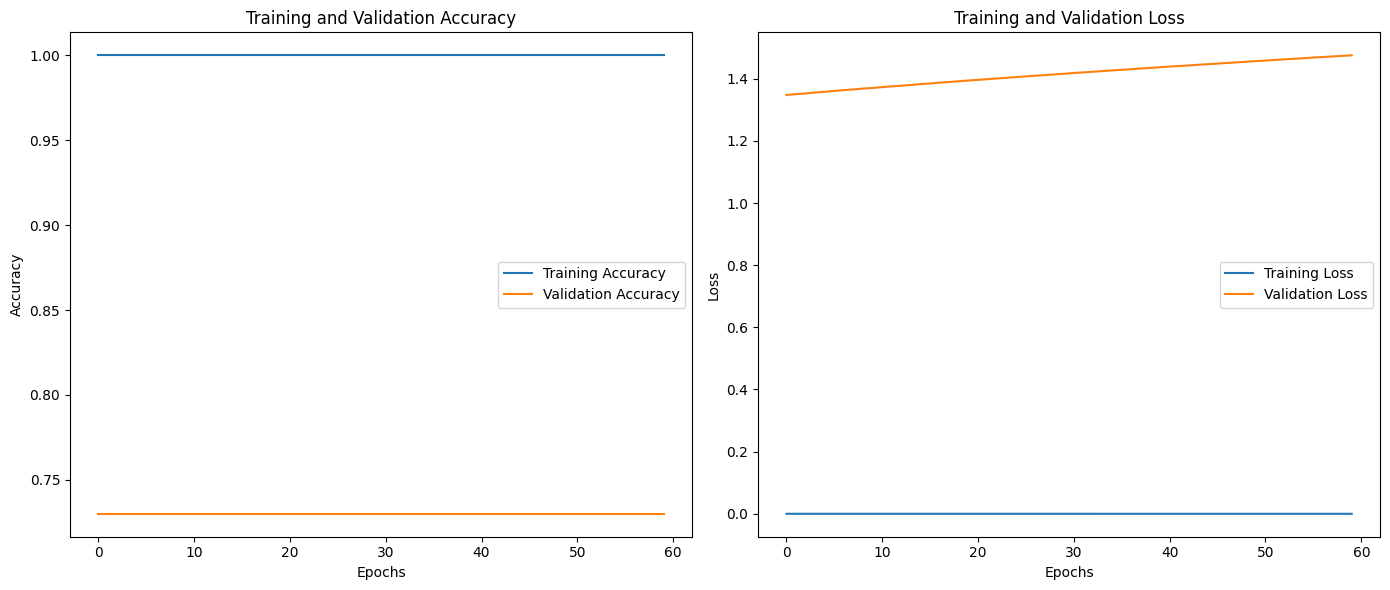

In [41]:
# Set the number of epochs and batch size
epochs = 60
batch_size = 32

# Train the model
history = model.fit(X_train_rnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rnn, y_test),
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Visualize the training and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3084e-06 - val_accuracy: 0.7300 - val_loss: 1.4773
Epoch 2/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.2475e-06 - val_accuracy: 0.7300 - val_loss: 1.4789
Epoch 3/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.5201e-06 - val_accuracy: 0.7300 - val_loss: 1.4808
Epoch 4/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.7165e-06 - val_accuracy: 0.7300 - val_loss: 1.4827
Epoch 5/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.3797e-06 - val_accuracy: 0.7300 - val_loss: 1.4843
Epoch 6/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9884e-06 - val_accuracy: 0.7300 - val_loss: 1.4863
Epoch 7/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.2357e-06 - val_accuracy: 0.7300 - val_loss: 1.4881
Epoch 8/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.5262e-06 - 

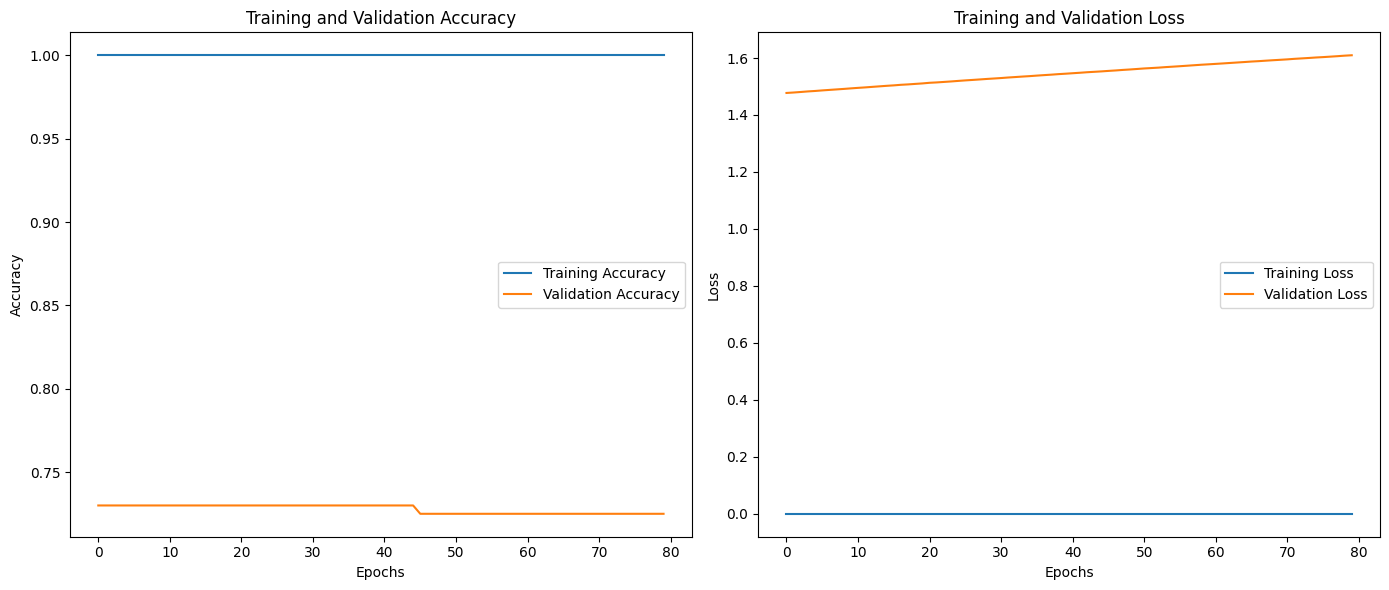

In [42]:
# Set the number of epochs and batch size
epochs = 80
batch_size = 32

# Train the model
history = model.fit(X_train_rnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rnn, y_test),
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Visualize the training and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.1315e-06 - val_accuracy: 0.7250 - val_loss: 1.6113
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8523e-06 - val_accuracy: 0.7250 - val_loss: 1.6126
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9790e-06 - val_accuracy: 0.7250 - val_loss: 1.6144
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8934e-06 - val_accuracy: 0.7250 - val_loss: 1.6159
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8890e-06 - val_accuracy: 0.7250 - val_loss: 1.6173
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.9560e-06 - val_accuracy: 0.7250 - val_loss: 1.6188
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1517e-06 - val_accuracy: 0.7250 - val_loss: 1.6205
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.823

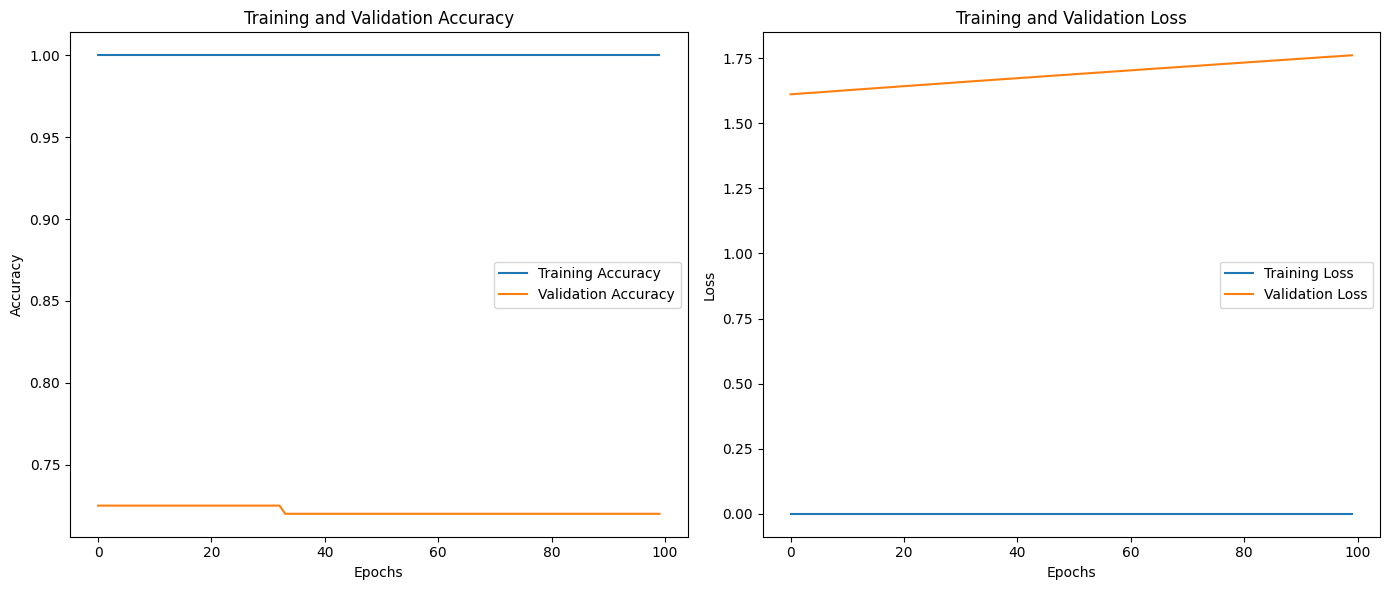

In [43]:
# Set the number of epochs and batch size
epochs = 100
batch_size = 32

# Train the model
history = model.fit(X_train_rnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_rnn, y_test),
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Visualize the training and validation accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
